# Apply Photometric Perturbations

This notebook demonstrates how to apply photometric perturbations, which are modifications to pixel intensity, color, and brightness properties, using NRTK.

We use a sample image from the [VisDrone](https://github.com/VisDrone/VisDrone-Dataset) dataset to demonstrate noise, blur, and enhancement perturbations.

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/photometric_perturbers.ipynb)

## Set Up the Environment

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

This notebook requires NRTK with the following extras: `headless`, `Pillow`, and `skimage`

- `headless` or `graphics` - OpenCV headless or graphics for blur perturbations
- `Pillow` - PIL for enhancement perturbations (brightness, color, contrast, sharpness)
- `skimage` - scikit-image for noise perturbations

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
%pip install -qU pip
print("Installing nrtk with required extras...")
try:
    import cv2  # noqa: F401 -- intentionally unused, just checking availability
    import PIL  # noqa: F401 -- intentionally unused, just checking availability
    import skimage  # noqa: F401 -- intentionally unused, just checking availability

    import nrtk  # noqa: F401 -- intentionally unused, just checking availability
except ImportError:
    %pip install -q "nrtk[headless,pillow,skimage]"
    pass  # jupytext converts %pip to a comment, so pass keeps the block valid
print("Installing matplotlib...")
%pip install -q matplotlib
print("Installing headless OpenCV...")
%pip uninstall -qy opencv-python opencv-python-headless
%pip install -q opencv-python-headless
print("Done!")

Note: you may need to restart the kernel to use updated packages.
Installing nrtk with required extras...


Installing matplotlib...


Note: you may need to restart the kernel to use updated packages.
Installing headless OpenCV...


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Done!


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
import os
import urllib.request
from typing import TYPE_CHECKING, Any

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from PIL import Image

from nrtk.impls.perturb_image.photometric.blur import AverageBlurPerturber, GaussianBlurPerturber, MedianBlurPerturber
from nrtk.impls.perturb_image.photometric.enhance import (
    BrightnessPerturber,
    ColorPerturber,
    ContrastPerturber,
    SharpnessPerturber,
)
from nrtk.impls.perturb_image.photometric.noise import (
    GaussianNoisePerturber,
    PepperNoisePerturber,
    SaltAndPepperNoisePerturber,
    SaltNoisePerturber,
    SpeckleNoisePerturber,
)

## Select Initial Image

We'll carry out perturbations on a single image from VisDrone.

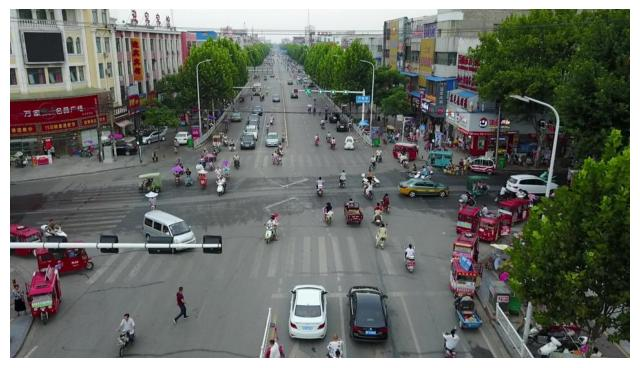

In [4]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"

img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img = np.asarray(Image.open(img_path))

plt.figure(figsize=(8, 8))
plt.axis("off")
_ = plt.imshow(img)

We'll also define a couple of helper functions for displaying our perturbations.

In [5]:
def display_pert(img: np.ndarray, descriptor: str = "") -> None:
    """Display perturbation."""
    _, axs = plt.subplots(figsize=(8, 8))
    if TYPE_CHECKING:
        assert isinstance(axs, Axes)
    axs.set_title(descriptor)
    axs.imshow(img)
    axs.axis("off")

In [6]:
def config_to_str(config: dict[str, Any]) -> str:
    """Generate string to describe config."""
    out = ", ".join([f"{k}={v}" for k, v in config.items()])

    return f"({out})"

## Noise Perturbers

Noise perturbations add different forms of random variation to the image, and are implemented using scikit-image’s noise functions. For all of these perturbers, you can specify a seed for reproducible results.

### Salt Noise Perturber

The `SaltNoisePerturber` replaces random pixels with 1.

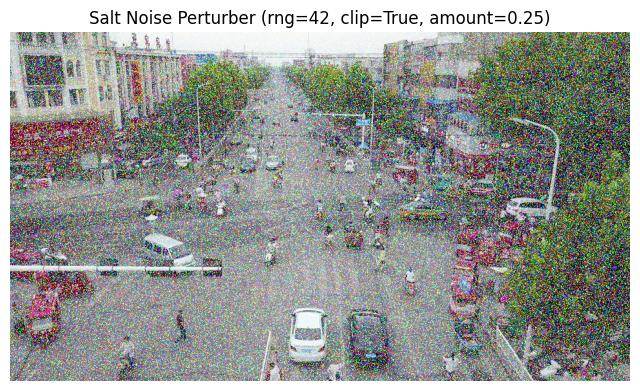

In [7]:
seed = 42
amount = 0.25

salt_noise_perturber = SaltNoisePerturber(
    seed=seed,
    amount=amount,
)
salt_noise_out, _ = salt_noise_perturber(image=img)
display_pert(salt_noise_out, f"Salt Noise Perturber {config_to_str(salt_noise_perturber.get_config())}")

Since we specified a seed, we can confirm that our results are reproducible:

In [8]:
salt_noise_perturber_2 = SaltNoisePerturber(
    seed=seed,
    amount=amount,
)
salt_noise_out_2, _ = salt_noise_perturber_2(image=img)
print(np.array_equal(salt_noise_out, salt_noise_out_2))
assert np.array_equal(salt_noise_out, salt_noise_out_2)  # noqa: S101

True


### Pepper Noise Perturber

The `PepperNoisePerturber` replaces random pixels with 0 (for unsigned images) or -1 (for signed images).

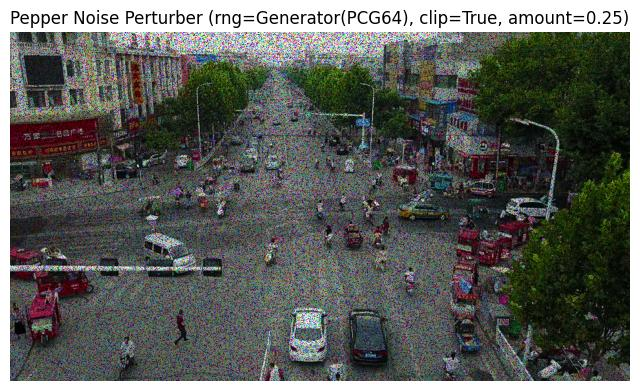

In [9]:
seed = 42
amount = 0.25

pepper_noise_perturber = PepperNoisePerturber(
    seed=seed,
    amount=amount,
)
pepper_noise_out, _ = pepper_noise_perturber(image=img)
display_pert(pepper_noise_out, f"Pepper Noise Perturber {config_to_str(pepper_noise_perturber.get_config())}")

Again, we can confirm that our results are reproducible by using the same seed.

In [10]:
pepper_noise_perturber_2 = PepperNoisePerturber(
    seed=seed,
    amount=amount,
)
pepper_noise_out_2, _ = pepper_noise_perturber_2(image=img)
print(np.array_equal(pepper_noise_out, pepper_noise_out_2))
assert np.array_equal(pepper_noise_out, pepper_noise_out_2)  # noqa: S101

True


### Salt and Pepper Noise Perturber

The `SaltAndPepperNoisePerturber` replaces random pixels with either salt or pepper noise. Just as before, reproducibility is possible with the `seed` parameter, but we won't continue to demonstrate that.

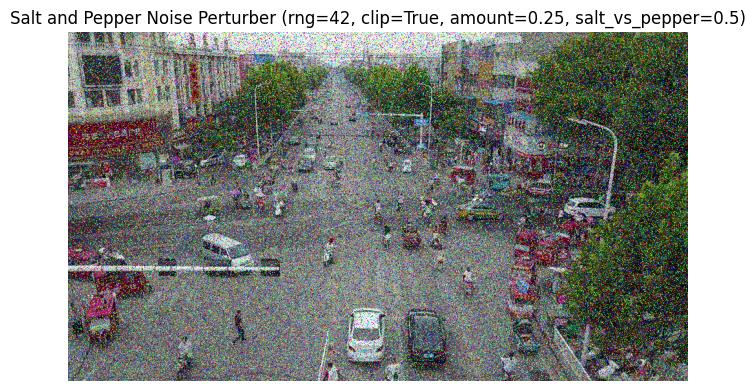

In [11]:
seed = 42
amount = 0.25
salt_vs_pepper = 0.5

sp_noise_perturber = SaltAndPepperNoisePerturber(
    seed=seed,
    amount=amount,
    salt_vs_pepper=salt_vs_pepper,
)
sp_noise_out, _ = sp_noise_perturber(image=img)
display_pert(sp_noise_out, f"Salt and Pepper Noise Perturber {config_to_str(sp_noise_perturber.get_config())}")

### Gaussian Noise Perturber

The `GaussianNoisePerturber` adds Gaussian-distributed noise to the image.

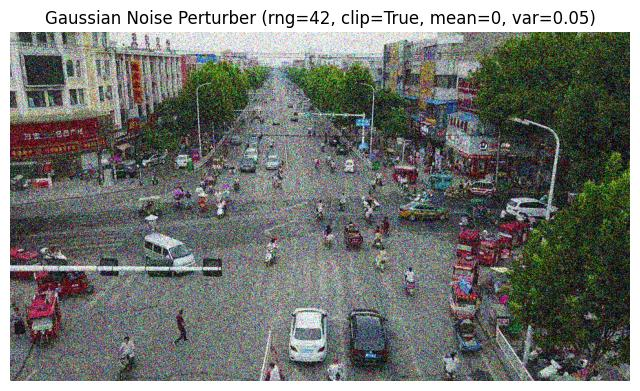

In [12]:
seed = 42
mean = 0
var = 0.05

gaussian_noise_perturber = GaussianNoisePerturber(
    seed=seed,
    mean=mean,
    var=var,
)
gaussian_noise_out, _ = gaussian_noise_perturber(image=img)
display_pert(gaussian_noise_out, f"Gaussian Noise Perturber {config_to_str(gaussian_noise_perturber.get_config())}")

### Speckle Noise Perturber

The `SpeckleNoisePerturber` adds multiplicative, Gaussian-distributed noise to the image.

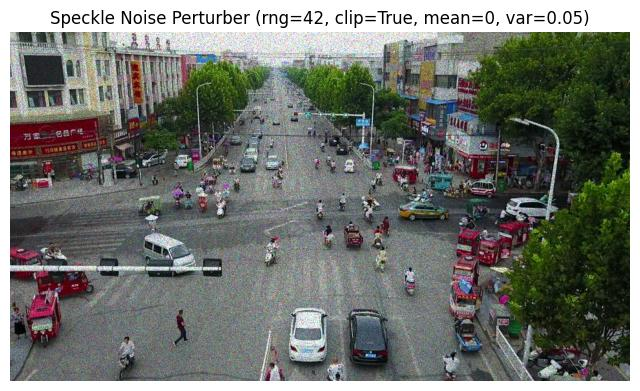

In [13]:
seed = 42
mean = 0
var = 0.05

speckle_noise_perturber = SpeckleNoisePerturber(
    seed=seed,
    mean=mean,
    var=var,
)
speckle_noise_out, _ = speckle_noise_perturber(image=img)
display_pert(speckle_noise_out, f"Speckle Noise Perturber {config_to_str(speckle_noise_perturber.get_config())}")

## Blur Perturbers

These blur perturbers apply various convolution-based smoothing operations and are implemented using OpenCV.

### Average Blur Perturber

The `AverageBlurPerturber` applies "average" blurring to the image stimulus. To achieve this, OpenCV convolves the image with a normalized box filter, so the average of the pixels under the kernel replaces the central element.

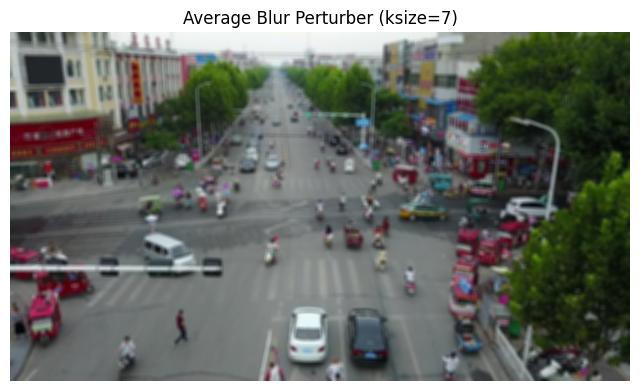

In [14]:
ksize = 7

avg_blur_perturber = AverageBlurPerturber(
    ksize=ksize,
)
avg_blur_out, _ = avg_blur_perturber(image=img)
display_pert(avg_blur_out, f"Average Blur Perturber {config_to_str(avg_blur_perturber.get_config())}")

### Gaussian Blur Perturber

The `GaussianBlurPerturber` applies Gaussian blurring to the image stimulus by using a Gaussian kernel instead of a normalized box filter.

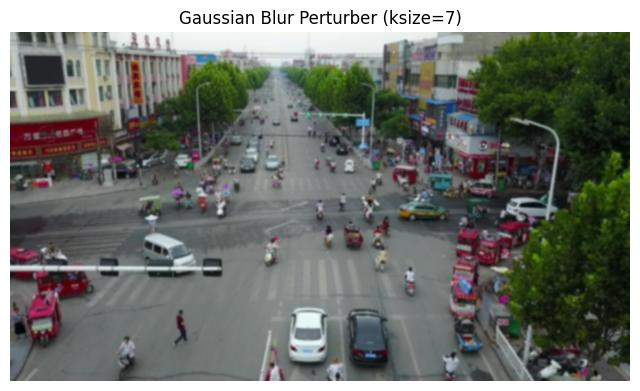

In [15]:
ksize = 7

gaussian_blur_perturber = GaussianBlurPerturber(
    ksize=ksize,
)
gaussian_blur_out, _ = gaussian_blur_perturber(image=img)
display_pert(gaussian_blur_out, f"Gaussian Blur Perturber {config_to_str(gaussian_blur_perturber.get_config())}")

### Median Blur Perturber

The `MedianBlurPerturber` applies median blurring to the image stimulus, where the central element is replaced with the median value of the pixels under the kernel.

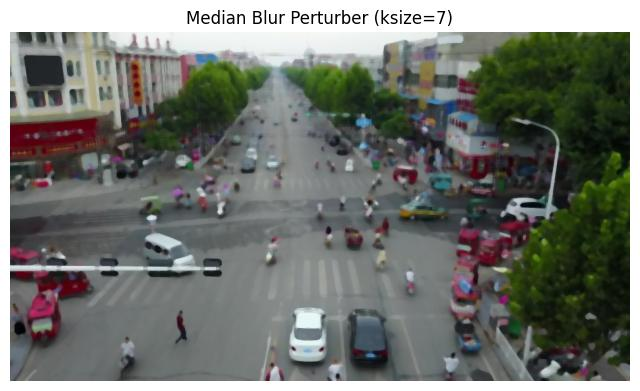

In [16]:
ksize = 7

median_blur_perturber = MedianBlurPerturber(
    ksize=ksize,
)
median_blur_out, _ = median_blur_perturber(image=img)
display_pert(median_blur_out, f"Median Blur Perturber {config_to_str(median_blur_perturber.get_config())}")

## Enhancement Perturbers

Enhancement perturbations adjust properties such as brightness, color balance, contrast, and sharpness, and are implemented using the Python Imaging Library (PIL). A factor of 1.0 returns a copy of the original image. Lower factor values mean less of the relevant property (e.g. darker for brightness), while higher values mean more (e.g. brighter for brightness).

### Brightness Perturber

The `BrightnessPerturber` adjusts the brightness of the image stimulus. 

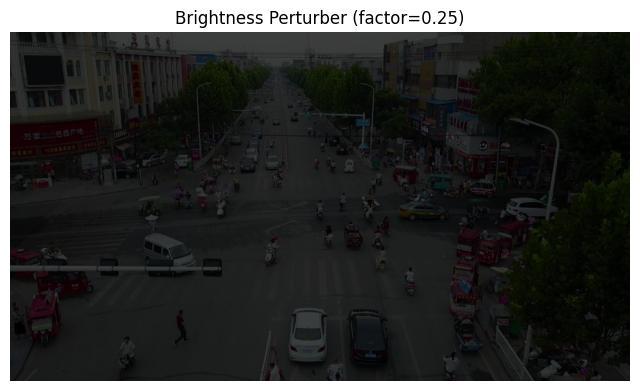

In [17]:
factor = 0.25

brightness_perturber = BrightnessPerturber(
    factor=factor,
)
brightness_out, _ = brightness_perturber(image=img)
display_pert(brightness_out, f"Brightness Perturber {config_to_str(brightness_perturber.get_config())}")

### Color Perturber

The `ColorPerturber` adjusts the color balance of the image stimulus. 

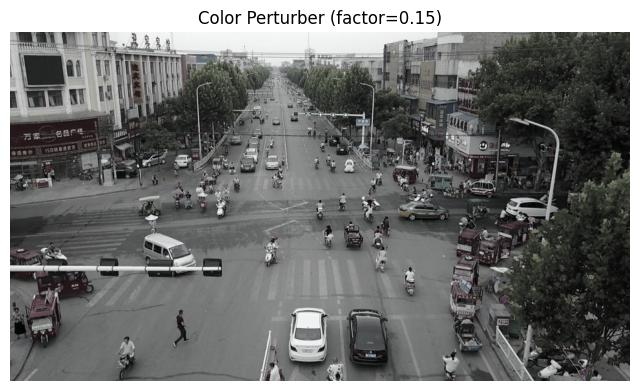

In [18]:
factor = 0.15

color_perturber = ColorPerturber(
    factor=factor,
)
color_out, _ = color_perturber(image=img)
display_pert(color_out, f"Color Perturber {config_to_str(color_perturber.get_config())}")

### Contrast Perturber

The `ContrastPerturber` adjusts the contrast of the image stimulus. 

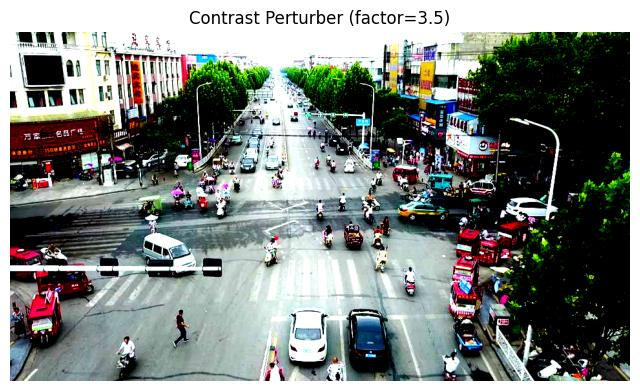

In [19]:
factor = 3.5

contrast_perturber = ContrastPerturber(
    factor=factor,
)
contrast_out, _ = contrast_perturber(image=img)
display_pert(contrast_out, f"Contrast Perturber {config_to_str(contrast_perturber.get_config())}")

### Sharpness Perturber

The `SharpnessPerturber` adjusts the sharpness of the image stimulus. The sharpness factor is limited to [0.0, 2.0]. 

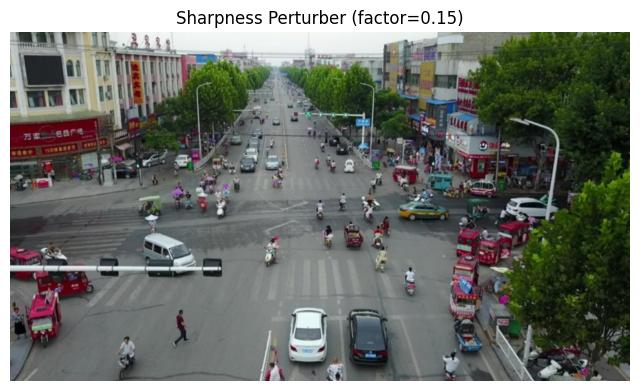

In [20]:
factor = 0.15

sharpness_perturber = SharpnessPerturber(
    factor=factor,
)
sharpness_out, _ = sharpness_perturber(image=img)
display_pert(sharpness_out, f"Sharpness Perturber {config_to_str(sharpness_perturber.get_config())}")